# MNIST Digit Addition Problem

Consider a task where one needs to learn a classifier $\mathtt{addition(X,Y,N)}$ where $\mathtt{X}$ and $\mathtt{Y}$ are images of digits (the MNIST data set will be used), and $\mathtt{N}$ is a natural number corresponding to the sum of these digits. The classifier should return an estimate of the validity of the addition ($0$ is invalid, $1$ is valid). 

For instance, if $\mathtt{X}$ is an image of a 0 and $\mathtt{Y}$ is an image of a 9:
- if $\mathtt{N} = 9$, then the addition is valid; 
- if $\mathtt{N} = 4$, then the addition is not valid. 

A natural approach is to seek to first 1) learn a single digit classifier, then 2) benefit from knowledge readily available about the properties of addition.
For instance, suppose that a predicate $\mathrm{digit}(x,d)$ gives the likelihood of an image $x$ being of digit $d$, one could query with LTN:    
$$
\exists d_1,d_2 : d_1+d_2= \mathtt{N} \ (\mathrm{digit}(\mathtt{X},d_1)\land \mathrm{digit}(\mathtt{Y},d_2))
$$
and use the satisfaction of this query as the output of $\mathtt{addition(X,Y,N)}$ .


The challenge is the following:
- We provide, in the data, pairs of images $\mathtt{X}$, $\mathtt{Y}$ and the result of the addition $\mathtt{N}$ (final label),
- We do **not** provide the intermediate labels, the correct digits for $d_1$, $d_2$.

Regardless, it is possible to use the equation above as background knowledge to train $\mathrm{digit}$ with LTN.
In contrast, a standard neural network baseline cannot incorporate such intermediate components as nicely.

In [1]:
# %resety

import tensorflow as tf
import ltn
import baselines, data, commons
import matplotlib.pyplot as plt


## Data

Dataset of images for the digits X and Y, and their label Z s.t. X+Y=Z.


Result label is 7


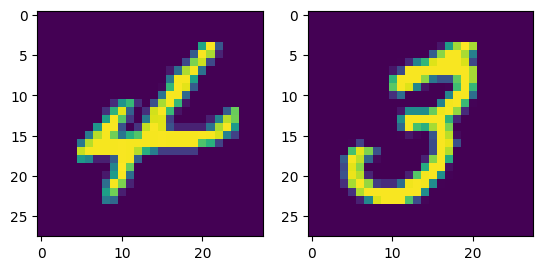

In [2]:

import tensorflow as tf
K = tf.keras.backend
K.clear_session()



def op_with_even_check(args):
    x, y = args[0], args[1]
    if x % 2 == 1 and y % 2 == 1:
        return x+y
    else:
        return x+y

ds_train, ds_test = data.get_mnist_op_dataset(
        count_train=3000,
        count_test=1000,
        buffer_size=3000,
        batch_size=16,
        n_operands=2,
        op=op_with_even_check)

# Visualize one example
x, y, z = next(ds_train.as_numpy_iterator())
plt.subplot(121)
plt.imshow(x[0][:,:,0])
plt.subplot(122)
plt.imshow(y[0][:,:,0])
print("Result label is %i" % z[0])

## LTN

In [3]:
logits_model = baselines.SingleDigit(inputs_as_a_list=True)
# from logictensornetwork.examples.mnist.baselines import StrongerSingleDigit
from baselines import StrongerSingleDigit


# logits_model = SingleDigit(inputs_as_a_list=True)
@tf.function
def digit_softmax_wrapper(x):
    return tf.nn.softmax(logits_model(x))

class SoftmaxDigitModel(tf.keras.Model):
    def __init__(self, base_model):
        super().__init__()
        self.base_model = base_model

    def call(self, x):
        logits = self.base_model(x)
        return tf.nn.softmax(logits)

softmax_model = SoftmaxDigitModel(logits_model)

Digit = ltn.Predicate.Lambda(lambda inputs: tf.gather(
    softmax_model([inputs[0]]),  # x
    indices=tf.cast(inputs[1], tf.int32),  # d
    axis=1,
    batch_dims=1
))

d1 = ltn.Variable("digits1", range(10))
d2 = ltn.Variable("digits2", range(10))

Not = ltn.Wrapper_Connective(ltn.fuzzy_ops.Not_Std())
And = ltn.Wrapper_Connective(ltn.fuzzy_ops.And_Prod())
Or = ltn.Wrapper_Connective(ltn.fuzzy_ops.Or_ProbSum())
Implies = ltn.Wrapper_Connective(ltn.fuzzy_ops.Implies_Reichenbach())
Forall = ltn.Wrapper_Quantifier(ltn.fuzzy_ops.Aggreg_pMeanError(),semantics="forall")
Exists = ltn.Wrapper_Quantifier(ltn.fuzzy_ops.Aggreg_pMean(),semantics="exists")

Notice the use of `Diag`: when grounding $x$,$y$,$n$ with three sequences of values, the $i$-th examples of each variable are matching. 
That is, `(images_x[i],images_y[i],labels[i])` is a tuple from our dataset of valid additions.
Using the diagonal quantification, LTN aggregates pairs of images and their corresponding result, rather than any combination of images and results. 
    
Notice also the guarded quantification: by quantifying only on the "intermediate labels" (not given during training) that could add up to the result label (given during training), we incorporate symbolic information into the system.

In [4]:
# mask
add = ltn.Function.Lambda(lambda inputs: inputs[0]+inputs[1])
equals = ltn.Predicate.Lambda(lambda inputs: inputs[0] == inputs[1])
is_even = ltn.Predicate.Lambda(lambda inputs: tf.equal(inputs[0] % 2, 0.0))
is_odd = ltn.Predicate.Lambda(lambda inputs: tf.equal(inputs[0] % 2, 1.0))
# minus_one = tf.constant(1, dtype=tf.int64)
# minus_one = ltn.Constant([-1.0], trainable=False)
# minus_one = ltn.Constant(-1.0)
one = ltn.Constant([1], trainable=False)
### Axioms
@tf.function
def axioms(images_x, images_y, labels_z, p_schedule=tf.constant(2.)):
    images_x = ltn.Variable("x", images_x)
    images_y = ltn.Variable("y", images_y)
    labels_z = ltn.Variable("z", labels_z)


#     axiomOne = Forall(
#             ltn.diag(images_x,images_y,labels_z),
#             Exists(
#                 (d1,d2),
#                 And(Digit([images_x,d1]),Digit([images_y,d2])),
#                mask = ltn.And(
#     equals([add([d1, d2]), labels_z]),
#     ltn.Or(is_even([d1]), is_even([d2]))
# ),
#                 p=p_schedule
#             ),
#             p=2
#         )
#     axiomOne = Forall(
#             ltn.diag(images_x,images_y,labels_z),
#             Exists(
#                 (d1,d2),
#                 And(Digit([images_x,d1]),Digit([images_y,d2])),
#                 # mask=equals([add([d1,d2]), labels_z]) and (is_even([d1]) or is_even([d2])),
#                 mask = And(
#     equals([add([d1, d2]), labels_z]),
#     Or(is_even([d1]), is_even([d2]))
# ),
#                 p=p_schedule
#             ),
#             p=2
#         )
#     axiomTwo = Forall(
#             ltn.diag(images_x,images_y,labels_z),
#             Exists(
#                 (d1,d2),
#                 And(Digit([images_x,d1]),Digit([images_y,d2])),
#                 # mask=equals([add([d1,d2]), labels_z]) and (is_even([d1]) or is_even([d2])),
#                 mask = And(
#     equals([add([d1, d2]), labels_z]),
#     And(is_odd([d1]), is_odd([d2]))
# ),
#                 p=p_schedule
#             ),
#             p=2
#         )

    axiomOne = Forall(
    ltn.diag(images_x, images_y, labels_z),
    Exists(
        (d1, d2),
        And(
            And(
                Digit([images_x, d1]),
                Digit([images_y, d2])
            ),
            And(
                equals([add([d1, d2]), labels_z]),
                Or(
                    is_even([d1]),
                    is_even([d2])
                )
            )
        ),
        p=p_schedule
    ),
    p=2
)

    axiomTwo = Forall(
    ltn.diag(images_x, images_y, labels_z),
    Exists(
        (d1, d2),
        And(
            And(
                Digit([images_x, d1]),
                Digit([images_y, d2])
            ),
            And(
                equals([add([d1, d2]), labels_z]),
                And(
                    is_odd([d1]),
                    is_odd([d2])
                )
            )
        ),
        p=p_schedule
    ),
    p=2
)


    sat = And(axiomOne, axiomTwo).tensor
    # sat = axiom.tensor
    return sat

images_x, images_y, labels_z = next(ds_train.as_numpy_iterator())
axioms(images_x, images_y, labels_z)

<tf.Tensor: shape=(), dtype=float32, numpy=2.1967434804537334e-06>

Optimizer, training steps and metrics

In [5]:
optimizer = tf.keras.optimizers.Adam(0.001)
metrics_dict = {
    'train_loss': tf.keras.metrics.Mean(name="train_loss"),
    'train_accuracy': tf.keras.metrics.Mean(name="train_accuracy"),
    'test_loss': tf.keras.metrics.Mean(name="test_loss"),
    'test_accuracy': tf.keras.metrics.Mean(name="test_accuracy")    
}

def op_with_even_check_tensor(args):
    x, y = args
    x_odd = tf.equal(x % 2, 1)
    y_odd = tf.equal(y % 2, 1)
    both_odd = tf.logical_and(x_odd, y_odd)
    # result = tf.where(both_odd, minus_one, x+y)
    # result = tf.where(both_odd, tf.cast(one.tensor, x.dtype), x + y)
    # result = tf.where(both_odd, x+y, x+y)
    # result = tf.where(both_odd, tf.cast(x + y, x.dtype), tf.cast(x + y, x.dtype))
    result = x+y

    return result

@tf.function
def train_step(images_x, images_y, labels_z, **parameters):
    # loss
    with tf.GradientTape() as tape:
        loss = 1.- axioms(images_x, images_y, labels_z, **parameters)
    gradients = tape.gradient(loss, logits_model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, logits_model.trainable_variables))
    metrics_dict['train_loss'](loss)
    # accuracy
    predictions_x = tf.argmax(logits_model([images_x]),axis=-1)
    predictions_y = tf.argmax(logits_model([images_y]),axis=-1)
    predictions_z =  op_with_even_check_tensor((predictions_x, predictions_y))
    match = tf.equal(predictions_z,tf.cast(labels_z,predictions_z.dtype))
    metrics_dict['train_accuracy'](tf.reduce_mean(tf.cast(match,tf.float32)))
    
@tf.function
def test_step(images_x, images_y, labels_z, **parameters):
    # loss
    loss = 1.- axioms(images_x, images_y, labels_z, **parameters)
    metrics_dict['test_loss'](loss)
    # accuracy
    predictions_x = tf.argmax(logits_model([images_x]),axis=-1)
    predictions_y = tf.argmax(logits_model([images_y]),axis=-1)
    predictions_z =  op_with_even_check_tensor((predictions_x, predictions_y))
    match = tf.equal(predictions_z,tf.cast(labels_z,predictions_z.dtype))
    metrics_dict['test_accuracy'](tf.reduce_mean(tf.cast(match,tf.float32)))
    return predictions_x, predictions_y, labels_z, predictions_z, images_x, images_y

Training

In [6]:
from collections import defaultdict

scheduled_parameters = defaultdict(lambda: {})
for epoch in range(0,4):
    scheduled_parameters[epoch] = {"p_schedule":tf.constant(1.)}
for epoch in range(4,8):
    scheduled_parameters[epoch] = {"p_schedule":tf.constant(2.)}
for epoch in range(8,12):
    scheduled_parameters[epoch] = {"p_schedule":tf.constant(4.)}
for epoch in range(12,20):
    scheduled_parameters[epoch] = {"p_schedule":tf.constant(6.)}
for epoch in range(20,30):
    scheduled_parameters[epoch] = {"p_schedule":tf.constant(8.)}


In [7]:
history = commons.train(
    epochs=30,
    metrics_dict=metrics_dict,
    ds_train=ds_train,
    ds_test=ds_test,
    train_step=train_step,
    test_step=test_step,
    scheduled_parameters=scheduled_parameters
)

Epoch 0, train_loss: 1.0000, train_accuracy: 0.0612, test_loss: 1.0000, test_accuracy: 0.0546
Epoch 1, train_loss: 1.0000, train_accuracy: 0.0745, test_loss: 1.0000, test_accuracy: 0.0764
Epoch 2, train_loss: 1.0000, train_accuracy: 0.0805, test_loss: 1.0000, test_accuracy: 0.0739
Epoch 3, train_loss: 1.0000, train_accuracy: 0.0938, test_loss: 1.0000, test_accuracy: 0.0813
Epoch 4, train_loss: 1.0000, train_accuracy: 0.0841, test_loss: 1.0000, test_accuracy: 0.0804
Epoch 5, train_loss: 1.0000, train_accuracy: 0.0854, test_loss: 1.0000, test_accuracy: 0.0794
Epoch 6, train_loss: 1.0000, train_accuracy: 0.0851, test_loss: 1.0000, test_accuracy: 0.0799
Epoch 7, train_loss: 1.0000, train_accuracy: 0.0854, test_loss: 1.0000, test_accuracy: 0.0794
Epoch 8, train_loss: 1.0000, train_accuracy: 0.0851, test_loss: 1.0000, test_accuracy: 0.0794
Epoch 9, train_loss: 1.0000, train_accuracy: 0.0851, test_loss: 1.0000, test_accuracy: 0.0794
Epoch 10, train_loss: 1.0000, train_accuracy: 0.0854, test_l

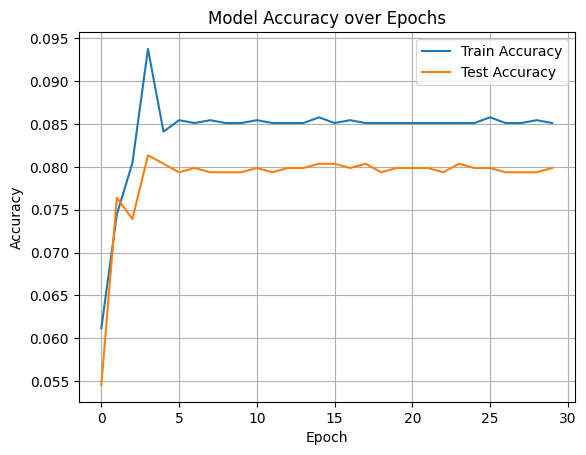

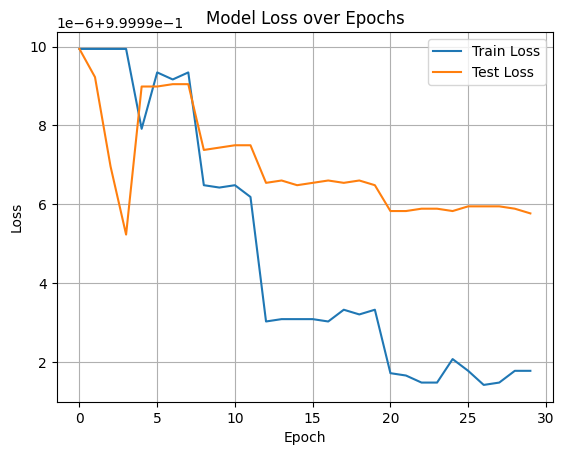

In [8]:
plt.figure()
plt.plot(range(len(history['train_accuracy'])), history['train_accuracy'], label='Train Accuracy')
plt.plot(range(len(history['test_accuracy'])), history['test_accuracy'], label='Test Accuracy')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Model Accuracy over Epochs")
plt.grid(True)
plt.legend()
plt.show()

# Plot Loss
plt.figure()
plt.plot(range(len(history['train_loss'])), history['train_loss'], label='Train Loss')
plt.plot(range(len(history['test_loss'])), history['test_loss'], label='Test Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Model Loss over Epochs")
plt.grid(True)
plt.legend()
plt.show()